In [1]:
import io
import os

# Imports the Google Cloud client library
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\rylee\GCloud\Path.json"

In [3]:
# Instantiates a client
client = speech.SpeechClient()

# The name of the audio file to transcribe
file_name = os.path.join(
    os.getcwd(),
    'harvard123.flac')

# Loads the audio into memory
with io.open(file_name, 'rb') as audio_file:
    content = audio_file.read()
    audio = types.RecognitionAudio(content=content)

config = types.RecognitionConfig(
    encoding=enums.RecognitionConfig.AudioEncoding.FLAC,
    audio_channel_count = 2,
    language_code='en-US')

# Detects speech in the audio file
response = client.recognize(config, audio)

for result in response.results:
    print('Transcript: {}'.format(result.alternatives[0].transcript))

In [7]:
from pydub import AudioSegment
audio = AudioSegment.from_file('test.flac')

In [8]:
audio.export(os.getcwd() + '\harvard123.flac', format = 'flac')

<_io.BufferedRandom name='C:\\Users\\rylee\\Jupyter notebooks\\HackHarvardGCloud\\harvard123.flac'>

In [16]:
import wave
import pyaudio
def getAudioInput(outputFile, CHUNK = 512, FORMAT = pyaudio.paInt16, CHANNELS = 2, RATE = 48000, RECORD_SECONDS = 1):
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []

    for j in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(outputFile, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

In [17]:
getAudioInput('poo2.flac', RECORD_SECONDS = 5)

* recording
* done recording


In [76]:
for i in range(5):
    getAudioInput('test' + str(i) + '.flac')

* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording
* recording
* done recording


In [ ]:
pyaudio.

In [81]:
audio3 = AudioSegment.from_file('test0.flac')
for i in range(1, 5):
    audio2 = AudioSegment.from_file('test' + str(i) + '.flac')
    audio3 = audio3.append(audio2)
audio3.export(os.getcwd() + '\poo.flac', format = 'flac')

<_io.BufferedRandom name='C:\\Users\\rylee\\Jupyter notebooks\\HackHarvardGCloud\\poo.flac'>

In [77]:
"""Synthesizes speech from the input string of text or ssml.

Note: ssml must be well-formed according to:
    https://www.w3.org/TR/speech-synthesis/
"""
from google.cloud import texttospeech

# Instantiates a client
client = texttospeech.TextToSpeechClient()

# Set the text input to be synthesized
synthesis_input = texttospeech.types.SynthesisInput(text="Can you tell me more about your experience at Denso??")

# Build the voice request, select the language code ("en-US") and the ssml
# voice gender ("neutral")
voice = texttospeech.types.VoiceSelectionParams(
    language_code='en-US',
    ssml_gender=texttospeech.enums.SsmlVoiceGender.NEUTRAL)

# Select the type of audio file you want returned
audio_config = texttospeech.types.AudioConfig(
    audio_encoding=texttospeech.enums.AudioEncoding.MP3)

# Perform the text-to-speech request on the text input with the selected
# voice parameters and audio file type
response = client.synthesize_speech(synthesis_input, voice, audio_config)

# The response's audio_content is binary.
with open('output.mp3', 'wb') as out:
    # Write the response to the output file.
    out.write(response.audio_content)
    print('Audio content written to file "output.mp3"')

Audio content written to file "output.mp3"


In [30]:
help(AudioSegment.get_array_of_samples)

Help on function get_array_of_samples in module pydub.audio_segment:

get_array_of_samples(self, array_type_override=None)
    returns the raw_data as an array of samples



In [63]:
x = audio.get_array_of_samples()

In [64]:
import numpy as np
np.array(x)

array([  0,   0,  -1, ..., -29,   2,   2], dtype=int16)

In [65]:
np.mean(x)

-0.004337754360465116

In [66]:
import matplotlib.pyplot as plt
len(x)

440320

In [67]:
np.amin(x)

-455

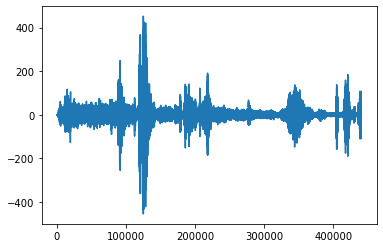

In [68]:
plt.plot(x)

In [18]:
#!/usr/bin/env python

# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Google Cloud Speech API sample application using the streaming API.
NOTE: This module requires the dependencies `pyaudio` and `termcolor`.
To install using pip:
    pip install pyaudio
    pip install termcolor
Example usage:
    python transcribe_streaming_infinite.py
"""

# [START speech_transcribe_infinite_streaming]

import time
import re
import sys

# uses result_end_time currently only avaialble in v1p1beta, will be in v1 soon
from google.cloud import speech_v1p1beta1 as speech
import pyaudio
from six.moves import queue

# Audio recording parameters
STREAMING_LIMIT = 10000
SAMPLE_RATE = 16000
CHUNK_SIZE = int(SAMPLE_RATE / 10)  # 100ms

RED = '\033[0;31m'
GREEN = '\033[0;32m'
YELLOW = '\033[0;33m'


def get_current_time():
    """Return Current Time in MS."""

    return int(round(time.time() * 1000))


class ResumableMicrophoneStream:
    """Opens a recording stream as a generator yielding the audio chunks."""

    def __init__(self, rate, chunk_size):
        self._rate = rate
        self.chunk_size = chunk_size
        self._num_channels = 1
        self._buff = queue.Queue()
        self.closed = True
        self.start_time = get_current_time()
        self.restart_counter = 0
        self.audio_input = []
        self.last_audio_input = []
        self.result_end_time = 0
        self.is_final_end_time = 0
        self.final_request_end_time = 0
        self.bridging_offset = 0
        self.last_transcript_was_final = False
        self.new_stream = True
        self._audio_interface = pyaudio.PyAudio()
        self._audio_stream = self._audio_interface.open(
            format=pyaudio.paInt16,
            channels=self._num_channels,
            rate=self._rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            # Run the audio stream asynchronously to fill the buffer object.
            # This is necessary so that the input device's buffer doesn't
            # overflow while the calling thread makes network requests, etc.
            stream_callback=self._fill_buffer,
        )

    def __enter__(self):

        self.closed = False
        return self

    def __exit__(self, type, value, traceback):

        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        # Signal the generator to terminate so that the client's
        # streaming_recognize method will not block the process termination.
        self._buff.put(None)
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, *args, **kwargs):
        """Continuously collect data from the audio stream, into the buffer."""

        self._buff.put(in_data)
        return None, pyaudio.paContinue

    def generator(self):
        """Stream Audio from microphone to API and to local buffer"""

        while not self.closed:
            data = []

            if self.new_stream and self.last_audio_input:

                chunk_time = STREAMING_LIMIT / len(self.last_audio_input)

                if chunk_time != 0:

                    if self.bridging_offset < 0:
                        self.bridging_offset = 0

                    if self.bridging_offset > self.final_request_end_time:
                        self.bridging_offset = self.final_request_end_time

                    chunks_from_ms = round((self.final_request_end_time -
                                            self.bridging_offset) / chunk_time)

                    self.bridging_offset = (round((
                        len(self.last_audio_input) - chunks_from_ms)
                                                  * chunk_time))

                    for i in range(chunks_from_ms, len(self.last_audio_input)):
                        data.append(self.last_audio_input[i])

                self.new_stream = False

            # Use a blocking get() to ensure there's at least one chunk of
            # data, and stop iteration if the chunk is None, indicating the
            # end of the audio stream.
            chunk = self._buff.get()
            self.audio_input.append(chunk)

            if chunk is None:
                return
            data.append(chunk)
            # Now consume whatever other data's still buffered.
            while True:
                try:
                    chunk = self._buff.get(block=False)

                    if chunk is None:
                        return
                    data.append(chunk)
                    self.audio_input.append(chunk)

                except queue.Empty:
                    break

            yield b''.join(data)


def listen_print_loop(responses, stream):
    """Iterates through server responses and prints them.
    The responses passed is a generator that will block until a response
    is provided by the server.
    Each response may contain multiple results, and each result may contain
    multiple alternatives; for details, see https://goo.gl/tjCPAU.  Here we
    print only the transcription for the top alternative of the top result.
    In this case, responses are provided for interim results as well. If the
    response is an interim one, print a line feed at the end of it, to allow
    the next result to overwrite it, until the response is a final one. For the
    final one, print a newline to preserve the finalized transcription.
    """

    for response in responses:

        if get_current_time() - stream.start_time > STREAMING_LIMIT:
            stream.start_time = get_current_time()
            break

        if not response.results:
            continue

        result = response.results[0]

        if not result.alternatives:
            continue

        transcript = result.alternatives[0].transcript

        result_seconds = 0
        result_nanos = 0

        if result.result_end_time.seconds:
            result_seconds = result.result_end_time.seconds

        if result.result_end_time.nanos:
            result_nanos = result.result_end_time.nanos

        stream.result_end_time = int((result_seconds * 1000)
                                     + (result_nanos / 1000000))

        corrected_time = (stream.result_end_time - stream.bridging_offset
                          + (STREAMING_LIMIT * stream.restart_counter))
        # Display interim results, but with a carriage return at the end of the
        # line, so subsequent lines will overwrite them.

        if result.is_final:

            sys.stdout.write(GREEN)
            sys.stdout.write('\033[K')
            sys.stdout.write(str(corrected_time) + ': ' + transcript + '\n')

            stream.is_final_end_time = stream.result_end_time
            stream.last_transcript_was_final = True

            # Exit recognition if any of the transcribed phrases could be
            # one of our keywords.
            if re.search(r'\b(exit|quit)\b', transcript, re.I):
                sys.stdout.write(YELLOW)
                sys.stdout.write('Exiting...\n')
                stream.closed = True
                break

        else:
            sys.stdout.write(RED)
            sys.stdout.write('\033[K')
            sys.stdout.write(str(corrected_time) + ': ' + transcript + '\r')

            stream.last_transcript_was_final = False


def main():
    """start bidirectional streaming from microphone input to speech API"""

    client = speech.SpeechClient()
    config = speech.types.RecognitionConfig(
        encoding=speech.enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=SAMPLE_RATE,
        language_code='en-US',
        max_alternatives=1)
    streaming_config = speech.types.StreamingRecognitionConfig(
        config=config,
        interim_results=True)

    mic_manager = ResumableMicrophoneStream(SAMPLE_RATE, CHUNK_SIZE)
    print(mic_manager.chunk_size)
    sys.stdout.write(YELLOW)
    sys.stdout.write('\nListening, say "Quit" or "Exit" to stop.\n\n')
    sys.stdout.write('End (ms)       Transcript Results/Status\n')
    sys.stdout.write('=====================================================\n')

    with mic_manager as stream:

        while not stream.closed:
            sys.stdout.write(YELLOW)
            sys.stdout.write('\n' + str(
                STREAMING_LIMIT * stream.restart_counter) + ': NEW REQUEST\n')

            stream.audio_input = []
            audio_generator = stream.generator()

            requests = (speech.types.StreamingRecognizeRequest(
                audio_content=content)for content in audio_generator)

            responses = client.streaming_recognize(streaming_config,
                                                   requests)

            # Now, put the transcription responses to use.
            listen_print_loop(responses, stream)

            if stream.result_end_time > 0:
                stream.final_request_end_time = stream.is_final_end_time
            stream.result_end_time = 0
            stream.last_audio_input = []
            stream.last_audio_input = stream.audio_input
            stream.audio_input = []
            stream.restart_counter = stream.restart_counter + 1

            if not stream.last_transcript_was_final:
                sys.stdout.write('\n')
            stream.new_stream = True

main()

1600

Listening, say "Quit" or "Exit" to stop.

End (ms)       Transcript Results/Status

0: NEW REQUEST
7650: I meanre you

10000: NEW REQUEST
17440: I'm not I'm not goinggo17920: I'm not I'm not going
25190:  it's fucking Shasta

20000: NEW REQUEST
21865: sister
27995:  said something

30000: NEW REQUEST
55061: I looked right into my phone first cuz I wasn't trying to get away round now

40000: NEW REQUEST
64004: Wake County

50000: NEW REQUEST
52050: gladion you
58650:  line of credit

60000: NEW REQUEST
61554: wrong with
68364:  argument research for love

70000: NEW REQUEST
71017: you know even though

80000: NEW REQUEST
88196: free launcher
93076:  good night

90000: NEW REQUEST
90678: Nuketown in the combinationn

100000: NEW REQUEST
134435: remindt

110000: NEW REQUEST
102010: I had to do some Keto101200: had to do some Keto
116790:  I need the number for phoe

120000: NEW REQUEST
122853: yeah I'm going to send you a link

130000: NEW REQUEST
131301: next New Year's

140000: NE